In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import numpy as np
import keras,gc,nltk
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.special import expit
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
nltk.download('reuters')
nltk.download('wordnet')
%matplotlib inline

from base_networks import *

np.random.seed(20)

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

[nltk_data] Downloading package reuters to /home/fmena/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fmena/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

### 20 Newsgroup
---

Utilizado en trabajos previos de *Hashing* de texto (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de usuarios asociados a temáticas de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|11.314|20|
|Pruebas|7.532|20|

In [2]:
dat_n = "20News"

from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_t.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


/home/fmena/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Es el dataset con los documentos más extensos en información o textos, lo que podría ser un indicador que es el más difícil ya que se deberá comprimir toda la información presente en estos textos.

### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987, citado también en el estado del arte (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|7.769|90|
|Pruebas|3.019|90|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque un texto asociado a una noticia puede hablar de varios tópicos a la vez. 

In [ ]:
dat_n = "Reuters"

from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

labels = reuters.categories()

#### top 20 labels (as VDSH)

In [ ]:
from utils import get_topK_labels,set_newlabel_list,enmask_data
new_labels = get_topK_labels(labels_t+labels_test, labels, K=20)
labels = new_labels
new_labels

El dataset anterior también es extenso en sus documentos pero no tan extremo como 20 Newsgroup.

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web en el buscador de Google. Pertenecientes a 8 clases únicas (dominio). Disponibles a través de http://jwebpro.sourceforge.net/data-web-snippets.tar.gz.


|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|10.060|8|
|Pruebas|2.280|8|

In [ ]:
dat_n = "Snippets"

def read_file(archivo,symb=' '):
    with open(archivo,'r') as f:
        lineas = f.readlines()
        tokens_f = [linea.strip().split(symb) for linea in lineas]
        labels = [tokens[-1] for tokens in tokens_f]
        tokens = [' '.join(tokens[:-1]) for tokens in tokens_f]
    return labels,tokens
labels_t,texts_t = read_file("Data/data-web-snippets/train.txt")
labels_test,texts_test = read_file("Data/data-web-snippets/test.txt")
print("Datos de entrenamiento: ",len(texts_t))
print("Datos de pruebas: ",len(texts_test))

labels = list(set(labels_t))
labels

Datos de entrenamiento:  10060
Datos de pruebas:  2280


['culture-arts-entertainment',
 'engineering',
 'business',
 'computers',
 'education-science',
 'health',
 'politics-society',
 'sports']

### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn** (https://scikit-learn.org/0.17/datasets/rcv1.html). La representación son las *features* ya extraídas.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|23.149|103|
|Pruebas|781.265|103|

Representación de **sklearn** viene pre-procesada con la transformación logarítmica de TF-IDF.

In [20]:
dat_n = "RCV1"

from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_t = rcv1_train.data
y_t = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target
labels = rcv1_train.target_names

del rcv1_train,rcv1_test
X_train

KeyboardInterrupt: 

In [ ]:
X_t = np.concatenate((X_t,X_test),axis=0)
labels_t = np.concatenate((X_t,X_test),axis=0) #labels


In [ ]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
X_t,X_test,labels_t,labels_test  = train_test_split(X_t,labels_t,random_state=20,test_size=0.1)

X_train,X_val,labels_train,labels_val  = train_test_split(X_t,labels_t,random_state=20,test_size=0.1)

del X_t, labels_t
gc.collect()

print("Vocabulario size = ",X_train.shape[1])
print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))

### TMC
---
textos relacionados con reportes aeros de tráfico provistos por la NASA y usados en la competencia de text mining SIAM. Cada texto tiene 22 etiquetas no exlucenyetes.


|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|21,519|22|
|Validación|3,498|22|
|Pruebas|3,498|22|

In [ ]:
dat_n = "TMC"

labels = ['a','b','c','d','e','f','e','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u']

### Validation creation

In [ ]:
from sklearn.model_selection import train_test_split
labels_t = np.asarray(labels_t)
labels_test = np.asarray(labels_test)
texts_train,texts_val,labels_train,labels_val  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.1)

print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  9054
Cantidad de datos Validación:  1006
Cantidad de datos Pruebas:  2280


In [ ]:
X_train_input = X_train
X_val_input = X_val
X_test_input = X_test

## Pre-process
---
Para obtener la representación de los datos, en primer lugar se normalizan con experimentar dos tipos de pre-procesamiento:

1. El primero es el siguiente (Basado en Deep Semantic Hashing)
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Conservar las top $k$ palabras/*tokens* más frecuentes
2. El segundo añade lo siguiente (Basado en Semantic Hashing)
    * Se realiza un *stemming* (Snowball) -- Lemmatization
    * Remover palabras de menos de 3 largo


Para la representación vectorial se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frequency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

La representación *term frequency* es la que se toma como base, puesto que resulta natural al momento de reconstruir el dato y poder utilizar la función de pérdida *cross entropy*. Ya que para la representación *tf-idf* requeriría una función de pérdida adecuada para variable continua, que podría ser *mse*.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
#analyzer = TfidfVectorizer(ngram_range=(1, 3)).build_analyzer()
tokenizer = TfidfVectorizer().build_tokenizer()
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

"""Extract features from raw input"""
def preProcess(s): #String processor
    return s.lower().strip().strip('-').strip('_')
def number_normalize(doc):
    results = []
    for token in tokenizer(doc):
        token_pro = preProcess(token)
        if len(token_pro) != 0 and not token_pro[0].isdigit():
            results.append(token_pro)
    return results
def stemmed_words(doc):
    results = []
    for token in tokenizer(doc):
        pre_pro = preProcess(token)
        #token_pro = stemmer.stem(pre_pro) #aumenta x10 el tiempo de procesamiento
        token_pro = lemmatizer.lemmatize(pre_pro) #so can explain/interpretae -- aumenta x5 el tiempo de proce
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

def get_transform_representation(mode, analizer,min_count,max_feat):
    smooth_idf_b = False
    use_idf_b = False
    binary_b = False

    if mode == 'binary':
        binary_b = True
    elif mode == 'tf':     
        pass #default is tf
    elif mode == 'tf-idf':
        use_idf_b = True
        smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    return TfidfVectorizer(stop_words='english',tokenizer=analizer,min_df=min_count, max_df=0.8, max_features=max_feat
                                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,norm=None
                                  ,ngram_range=(1, 3)) 

min_count = 1 #default = 1
max_feat = 10000 #Best: 10000 -- Hinton (2000)


vectorizer = get_transform_representation("tf", stemmed_words,min_count,max_feat)

%time vectorizer.fit(texts_train)
vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_test)

token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}

#vectorizer2 = get_transform_representation("tf-idf", stemmed_words,min_count,max_feat)

#%time vectorizer2.fit(texts_train)
#vectors_train2 = vectorizer2.transform(texts_train)
#vectors_val2 = vectorizer2.transform(texts_val)
#vectors_test2 = vectorizer2.transform(texts_test)
vectors_train.shape

/home/fmena/.local/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 2.89 s, sys: 41.2 ms, total: 2.93 s
Wall time: 2.92 s


(9054, 10000)

En la celda anterior se calculan dos representaciones deseables de los datos, *term frequency* y *tf-idf*. A continuación se muestra cómo quedó el vocabulario.

In [ ]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())

#X_train2 = np.asarray(vectors_train2.todense())
#X_val2 = np.asarray(vectors_val2.todense())
#X_test2 = np.asarray(vectors_test2.todense())

del vectors_train,vectors_val,vectors_test#,vectors_train2,vectors_val2,vectors_test2
gc.collect()

X_train[0]

array([0., 0., 0., ..., 0., 0., 0.])

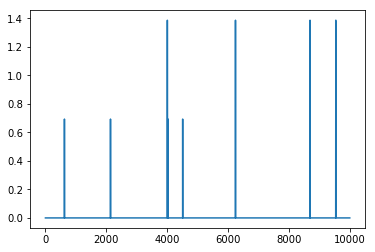

In [ ]:
##representacion soft para TF ---mucho mejor!
X_train_input = np.log(X_train+1) 
X_val_input = np.log(X_val+1) 
X_test_input = np.log(X_test+1) 
plt.plot(X_train_input[0])
plt.show()

#soft para tf-idf
#X_train_input2 = np.log(X_train2+1) 
#X_val_input2 = np.log(X_val2+1) 
#X_test_input2 = np.log(X_test2+1) 

### Model Architecture
---
La arquitectura para afrontar el problema es una red clásica *Feed Forward* basado en el *baseline* de *Variational Deep Semantic Hashing* (VDSH), la cual es una arquitectura de *autoencoder* no simétrico con dos capas escondidas en el *encoder* y sin capas escondidas en el *decoder*.


> Input(|V|) -> Relu(500) -> Relu (500) -> Laten variable(32)-> Sampling -> Softmax(|V|)


Tamién se experimenta con una arquitectura de autoencoder simétrico, lo cual asimila de mejor manera lo que es una RBM (red bidireccional) como se realiza en el trabajo de *Semantic Hashing*.

La primera experimentación se realiza con 32 *bits* en la representación latente, ya que los trabajos previos han mostrado que esta cantidad de *bits* parece ser lo suficiente antes de empezar a realizar *overfitting*.

In [3]:
def REC_loss(x_true, x_pred):
    x_pred = K.clip(x_pred, K.epsilon(), 1)
    return - K.sum(x_true*K.log(x_pred), axis=-1) #keras.losses.categorical_crossentropy(x_true, x_pred)


In [4]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, summ=True, beta=0):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    if summ:
        print("generator network:")
        generator.summary()

    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)
        
    Recon_loss = REC_loss
    kl_loss = KL_loss(z_mean,z_log_var)
    def VAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt, loss=VAE_loss, metrics = [Recon_loss,kl_loss])
    
    return traditional_vae, encoder,generator

In [5]:
import keras.backend as K
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)


def binary_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam',BN=True, summ=True,tau_ann=False,beta=0):
    if tau_ann:
        tau = K.variable(1.0, name="temperature") 
    else:
        tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3
    
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units,BN=BN)
    if summ:
        print("pre-encoder network:")
        pre_encoder.summary()
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units,BN=BN)
    if summ:
        print("generator network:")
        generator.summary()

    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    #dist = Dense(Nb, activation='sigmoid')(hidden) #p(b) #otra forma de modelarlo
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)
        
    Recon_loss = REC_loss
    kl_loss = BKL_loss(logits_b)
    def BVAE_loss(y_true, y_pred): 
        return Recon_loss(y_true, y_pred) + beta*kl_loss(y_true, y_pred)

    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=BVAE_loss, metrics = [Recon_loss,kl_loss])
    if tau_ann:
        return binary_vae, encoder,generator ,tau
    else:
        return binary_vae, encoder,generator

### Train details
---

* 30* epochs* 
* *batch size* de 100
* optimizador Adam
* Inicializador de Glorot (para los pesos)


In [6]:
from utils import  compare_hist_train, add_hist_plot

batch_size = 100
epochs = 30

In [ ]:
from utils_VDSH import Load_Dataset
#https://github.com/unsuthee/VariationalDeepSemanticHashing
## load data used for VDSH - for sake comparison


#filename = 'Data/ng20.tfidf.mat'
#filename = 'Data/reuters.tfidf.mat'
filename = 'Data/tmc.tfidf.mat'
data = Load_Dataset(filename)

X_train_input = data.train
X_train = X_train_input 
X_val_input = data.cv
X_val = X_val_input 
X_test_input = data.test
X_test = X_test_input


if "ng20" in filename:
    labels_train = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_train])
    labels_val = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_cv])
    labels_test = np.asarray([labels[value.argmax(axis=-1)] for value in data.gnd_test])
elif "reuters" in filename or "tmc" in filename:
    labels = np.asarray(labels)
    labels_train = np.asarray([labels[value.astype(bool)] for value in data.gnd_train])
    labels_val = np.asarray([labels[value.astype(bool)] for value in data.gnd_cv])
    labels_test = np.asarray([labels[value.astype(bool)] for value in data.gnd_test])

print("Cantidad de datos Entrenamiento: ",len(labels_train))
print("Cantidad de datos Validación: ",len(labels_val))
print("Cantidad de datos Pruebas: ",len(labels_test))
labels_train

# IMPORTANTE EJECUTAR, nueva modificación!

In [ ]:
#outputs as probabolities -- normalized over datasets..
X_train = X_train/X_train.sum(axis=-1,keepdims=True) 
X_val = X_val/X_val.sum(axis=-1,keepdims=True)
X_test = X_test/X_test.sum(axis=-1,keepdims=True)
print("Output target normalizado en dataset ",dat_n)

In [ ]:
X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

In [ ]:
from utils import find_beta

def create_model_T(beta_V):
    return traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)
def create_model_B(beta_V):
    return binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0
                                                                  ,beta=beta_V, summ=False)

In [ ]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True)

***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.1160
1,0.500000,0.1384
2,0.250000,0.1837
3,0.125000,0.2772
4,0.062500,0.4818
5,0.031250,0.4367
6,0.015625,0.3669
7,0.007812,0.3435
8,0.003906,0.3264
9,0.001953,0.3224


Best value is 0.4818 with beta 0.062500
Worst value is 0.1160 with beta 1.000000
***************************************
***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.1095
1,0.500000,0.1276
2,0.250000,0.1184
3,0.125000,0.1320
4,0.062500,0.2183
5,0.031250,0.4393
6,0.015625,0.5493
7,0.007812,0.5459
8,0.003906,0.5452
9,0.001953,0.5408


Best value is 0.5493 with beta 0.015625
Worst value is 0.1095 with beta 1.000000
***************************************


In [10]:
beta_T = 0.06250
beta_B = 0.01562

In [10]:
print("Valores de beta en VAE para dataset %s es %f"%(dat_n, beta_T))
print("Valores de beta en B-VAE para dataset %s es %f"%(dat_n, beta_B))

Valores de beta en VAE para dataset 20News es 0.062500
Valores de beta en B-VAE para dataset 20News es 0.015625


In [ ]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True)

***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.4873
1,0.500000,0.5345
2,0.250000,0.6152
3,0.125000,0.7481
4,0.062500,0.7548
5,0.031250,0.7028
6,0.015625,0.6385
7,0.007812,0.6076
8,0.003906,0.5801
9,0.001953,0.5595


Best value is 0.7548 with beta 0.062500
Worst value is 0.4873 with beta 1.000000
***************************************
***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.4973
1,0.500000,0.4801
2,0.250000,0.4733
3,0.125000,0.5280
4,0.062500,0.6596
5,0.031250,0.7732
6,0.015625,0.7902
7,0.007812,0.7930
8,0.003906,0.7935
9,0.001953,0.7891


Best value is 0.7962 with beta 0.000008
Worst value is 0.4733 with beta 0.250000
***************************************


In [ ]:
print("Valores de beta en VAE para dataset %s es %f"%(dat_n, beta_T))
print("Valores de beta en B-VAE para dataset %s es %f"%(dat_n, beta_B))

Valores de beta en VAE para dataset Reuters es 0.062500
Valores de beta en B-VAE para dataset Reuters es 0.000008


In [ ]:
beta_T = 0.06250
beta_B = 0.000008

In [ ]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True)

***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.5752
1,0.500000,0.5879
2,0.250000,0.6093
3,0.125000,0.6508
4,0.062500,0.7094
5,0.031250,0.6996
6,0.015625,0.6570
7,0.007812,0.6361
8,0.003906,0.6288
9,0.001953,0.6202


Best value is 0.7094 with beta 0.062500
Worst value is 0.5752 with beta 1.000000
***************************************
***************************************
*********** SUMMARY RESULTS ***********
***************************************


,beta,score
0,1.000000,0.5637
1,0.500000,0.5537
2,0.250000,0.5473
3,0.125000,0.5908
4,0.062500,0.6602
5,0.031250,0.7180
6,0.015625,0.7281
7,0.007812,0.7226
8,0.003906,0.7253
9,0.001953,0.7308


Best value is 0.7329 with beta 0.000244
Worst value is 0.5473 with beta 0.250000
***************************************


In [ ]:
print("Valores de beta en VAE para dataset %s es %f"%(dat_n, beta_T))
print("Valores de beta en B-VAE para dataset %s es %f"%(dat_n, beta_B))

Valores de beta en VAE para dataset TMC es 0.062500
Valores de beta en B-VAE para dataset TMC es 0.000244


In [ ]:
beta_T = 0.06250
beta_B = 0.000244

In [ ]:
beta_T = find_beta(create_model_T, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=False)
beta_B = find_beta(create_model_B, X_train_input, X_train, X_val_input,labels_train,labels_val,
                   binary=True)

KeyboardInterrupt: 

In [ ]:
print("Valores de beta en VAE para dataset %s es %f"%(dat_n, beta_T))
print("Valores de beta en B-VAE para dataset %s es %f"%(dat_n, beta_B))

In [ ]:
traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_T)

hist1 = traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val))

In [ ]:
binary_vae,encoder_Bvae,generator_Bvae= binary_VAE(X_train.shape[1],Nb=32,units=500,layers_e=2,layers_d=0,beta=beta_B)

hist2 = binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val_input,X_val) )
                       #,callbacks=[Tau_Call(tau)] )

In [ ]:
## kl increase va a depender netamente del problema, que tan rapido aprende el modelo y como vaariar eso..

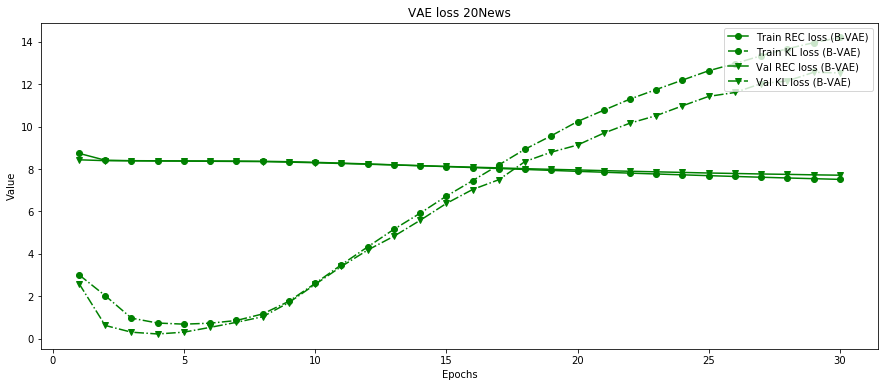

In [13]:
plt.figure(figsize=(15,6))
add_hist_plot(hist2, c='g', model_n = "B-VAE")
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss "+dat_n)
plt.show()

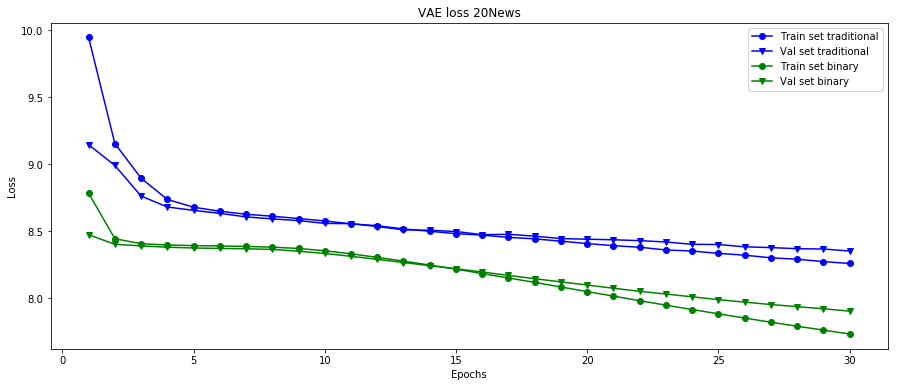

In [14]:
compare_hist_train(hist1,hist2, dat_n)

In [ ]:
plt.figure(figsize=(15,6))
add_hist_plot(hist2, c='g', model_n = "B-VAE")
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss "+dat_n)
plt.show()

In [ ]:
compare_hist_train(hist1,hist2, dat_n)

In [ ]:
plt.figure(figsize=(15,6))
add_hist_plot(hist2, c='g', model_n = "B-VAE")
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc="upper right", fancybox= True)
plt.title("VAE loss "+dat_n)
plt.show()

In [ ]:
compare_hist_train(hist1,hist2, dat_n)

### Another intrinsic measure: *Classification*


In [15]:
#function to define and train model
from sklearn.metrics import jaccard_score
from utils import define_fit, visualize_probas, visualize_mean, calculate_hash, visualize_probas_byB

results = []
results_S = []
results_B = []
results_O_B = [] #original testing on tresholded

In [ ]:
#codify input data (binarize -- or aprox)
X_train_logits = encoder_Bvae.predict(X_train_input)
X_val_logits = encoder_Bvae.predict(X_val_input)

#probabilities
X_train_Bcode = expit(X_train_logits)
X_val_Bcode = expit(X_val_logits)

#Z-mean
X_train_Tcode = encoder_Tvae.predict(X_train_input)
X_val_Tcode = encoder_Tvae.predict(X_val_input)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list or type(aux_labels) == np.ndarray :
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
C_val = codify_labels(labels_val)
C_train

20News


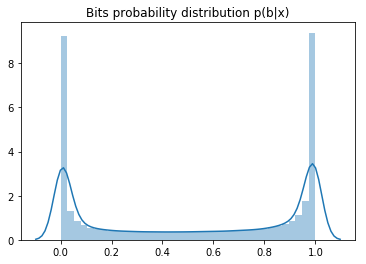

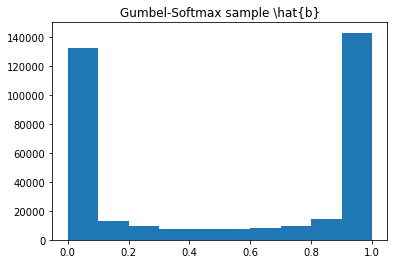

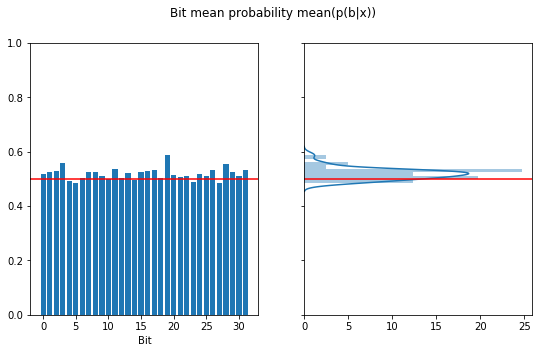

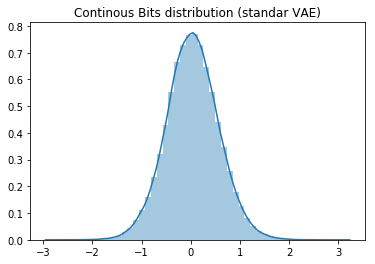

In [17]:
print(dat_n)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

In [ ]:
print(dat_n)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

In [ ]:
print(dat_n)
visualize_probas(X_train_logits, X_train_Bcode)

visualize_probas_byB(X_train_Bcode)

visualize_mean(X_train_Tcode)

In [ ]:
aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux

model1_O = define_fit(multi_label,X_train_Bcode,C_train)
model2_O = define_fit(multi_label,X_train_Tcode,C_train)
model3 = define_fit(multi_label,X_train_input,C_train)

if not multi_label:
    aux.append(model3.evaluate(X_train_input,C_train,verbose=0)[1])
    aux.append(model3.evaluate(X_val_input,C_val,verbose=0)[1])

    aux.append(model2_O.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model3.predict(X_train_input)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model3.predict(X_val_input)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

In [ ]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Raw Input (train-val): %f - %f"%(valores[1],valores[2]))
    print("Traditional VAE (train-val): %f - %f"%(valores[3],valores[4]))
    print("Binary VAE (train-val): %f - %f"%(valores[5],valores[6]))

In [ ]:
### sample

def samp_norm(mean, eps_std = 1):
    epsilon = np.random.normal(0,eps_std, size=mean.shape[1:])
    return mean + 1*epsilon #mu+sigma (desvest)
def samp_gumb(logits, tau=0.67, limits=[0,1]):
    eps = 1e-7
    U = np.random.uniform(limits[0], limits[1], size=logits.shape)
    b = logits + np.log( U/(1-U) + eps)
    return expit(b/tau) 

#reduce noise variability to perform a less stochastic sample

X_train_Tsamp = samp_norm(X_train_Tcode, eps_std=0.4)
X_val_Tsamp = samp_norm(X_val_Tcode, eps_std=0.4)

X_train_Bsamp = samp_gumb(X_train_logits, tau=0.5, limits=[0.3,0.7])
X_val_Bsamp = samp_gumb(X_val_logits, tau=0.5, limits=[0.3,0.7])

np.round(X_val_Bsamp, 2)

In [ ]:
aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux

model1 = define_fit(multi_label,X_train_Bsamp,C_train)
model2 = define_fit(multi_label,X_train_Tsamp,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tsamp,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tsamp,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bsamp,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bsamp,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tsamp)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tsamp)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bsamp)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bsamp)>=0.5)*1, average='micro'))
    
results_S.append(aux)
print("Done")

In [ ]:
print("Classification on Sampled representation")
for valores in results_S:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

In [ ]:
## binary // treshold it

X_train_Tcode_B = calculate_hash(X_train_Tcode, from_probas=False)
X_val_Tcode_B = calculate_hash(X_val_Tcode, from_probas=False)

X_train_Bcode_B = calculate_hash(X_train_Bcode, from_probas=True, from_logits=False)
X_val_Bcode_B = calculate_hash(X_val_Bcode, from_probas=True, from_logits=False)

X_train_Tcode_B

In [ ]:
### trained models over encoder representation testing on tresholded representation (see how decrease)

aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux
if not multi_label:
    aux.append(model2_O.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2_O.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1_O.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1_O.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2_O.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2_O.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1_O.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1_O.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_O_B.append(aux)
print("Done")

In [ ]:
print("Classification on Binary (thresholded) representation")
for valores in results_O_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

In [ ]:
aux = [dat_n]
multi_label = "Reuters" in aux or "TMC" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

In [ ]:
print("Classification on Binary (thresholded) representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

### Results
---
#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.
    

In [28]:
from utils import MedianHashing, get_similar, measure_metrics, calculate_hash 

### Experimentando variando el #Bits
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [29]:
def evaluate_hashing(encoder,train,val,labels_train, labels_val, traditional=True,tipo="topK"):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    
    train_hash = calculate_hash(encode_train, from_probas=~traditional )
    val_hash = calculate_hash(encode_val, from_probas=~traditional)

    val_similares_train =  get_similar(val_hash, train_hash, tipo=tipo,K=100) 
    return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)

In [30]:
traditional_dat = {"20news":{"p":[],"r":[]},
                   "snippets":{"p":[],"r":[]},
                   "reuters":{"p":[],"r":[]},
                  "tmc":{"p":[],"r":[]}}
binary_dat = {"20news":{"p":[],"r":[]},
              "snippets":{"p":[],"r":[]},
              "reuters":{"p":[],"r":[]},
             "tmc":{"p":[],"r":[]}}

In [ ]:
Nbits = np.asarray([4,8,16,32,64])
dataset = dat_n.lower()
print(dataset)

for Nbit in Nbits:
    traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_T)
    traditional_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_t,r_t = evaluate_hashing(encoder_Tvae,X_train_input,X_val_input,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    
    binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=Nbit,units=500,layers_e=2,layers_d=0,beta=beta_B)
    binary_vae.fit(X_train_input, X_train, epochs=epochs, batch_size=batch_size,verbose=0 )
    p_b,r_b = evaluate_hashing(encoder_Bvae,X_train_input,X_val_input,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    keras.backend.clear_session()
    gc.collect()

In [ ]:
print("Resultados de Precision en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["p"]
t["Reuters"] = traditional_dat["reuters"]["p"]
#t["Snippets"] = traditional_dat["snippets"]["p"]
t["TMC"] = traditional_dat["tmc"]["p"]
print("\n*** VAE Traditional***")
print(t)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["p"]
t["Reuters"] = binary_dat["reuters"]["p"]
#t["Snippets"] = binary_dat["snippets"]["p"]
t["TMC"] = binary_dat["tmc"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = traditional_dat["20news"]["r"]
t["Reuters"] = traditional_dat["reuters"]["r"]
#t["Snippets"] = traditional_dat["snippets"]["r"]
t["TMC"] = traditional_dat["tmc"]["r"]
print("\n*** VAE Traditional***")
print(t)

t = pd.DataFrame() #Table()
t["N bits"] = Nbits
t["20News"] = binary_dat["20news"]["r"]
t["Reuters"] = binary_dat["reuters"]["r"]
#t["Snippets"] = binary_dat["snippets"]["r"]
t["TMC"] = binary_dat["tmc"]["r"]
print("\n*** VAE Binary***")
print(t)

In [22]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["Snippets"] = traditional_dat["snippets"]["p"]
print("\n*** VAE Traditional***")
print(t)

t = Table()
t["N bits"] = Nbits
t["Snippets"] = binary_dat["snippets"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["Snippets"] = traditional_dat["snippets"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["Snippets"] = binary_dat["snippets"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación


NameError: name 'Table' is not defined

In [23]:
import pandas as pd
df = pd.read_csv("aux.txt", sep="\s+", header=None)
df = df.T#*100
df = df.round(3)
df
df.to_latex()

FileNotFoundError: File b'aux.txt' does not exist

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [ ]:
def evaluate_hashing(encoder,train,test,labels_trainn,labels_testt,traditional=True,tipo="topK"):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    encode_train = encoder.predict(train)
    encode_test = encoder.predict(test)
    train_hash = calculate_hash(encode_train, from_probas=~traditional )
    test_hash = calculate_hash(encode_test, from_probas=~traditional)

    test_similares_train =  get_similar(test_hash,train_hash,tipo="topK",K=100)
    return measure_metrics(labels,test_similares_train,labels_query=labels_testt,labels_source=labels_trainn)

#to save results
results_dat = {"20news":{"p":[],"r":[]},
               "snippets":{"p":[],"r":[]},
               "reuters":{"p":[],"r":[]},
              "tmc":{"p":[],"r":[]},
              } #for topk
BITS = 32

In [ ]:
X_total_input = np.concatenate((X_train_input,X_val_input),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)

traditional_vae,encoder_Tvae,generator_Tvae = traditional_VAE(X_train.shape[1],Nb=BITS,units=500,layers_e=2,layers_d=0,beta=beta_T)
traditional_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

binary_vae,encoder_Bvae,generator_Bvae = binary_VAE(X_train.shape[1],Nb=BITS,units=500,layers_e=2,layers_d=0,beta=beta_B)
binary_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

In [ ]:
dataset = dat_n.lower()

p_t,r_t = evaluate_hashing(encoder_Tvae,X_total_input,X_test_input,labels_total,labels_test,traditional=True,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)
print("Realizado sobre dataset ",dataset,"con precision y recall para VAE",p_t,r_t)

p_b,r_b = evaluate_hashing(encoder_Bvae,X_total_input,X_test_input,labels_total,labels_test,traditional=False,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
print("Realizado sobre dataset ",dataset,"con precision y recall para B-VAE",p_b,r_b)

In [ ]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = pd.DataFrame() #Table()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["p"]
t["Reuters"] = results_dat["reuters"]["p"]
#t["Snippets"] = results_dat["snippets"]["p"]
t["TMC"] = results_dat["tmc"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = pd.DataFrame()
t["Modelo"] = ["Tradicional","Binario"]
t["20News"] = results_dat["20news"]["r"]
t["Reuters"] = results_dat["reuters"]["r"]
#t["Snippets"] = results_dat["snippets"]["r"]
t["TMC"] = results_dat["tmc"]["r"]
print(t)

La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [ ]:
traditional_dat_BS = {"20news":{"p":[],"r":[]},
                      "snippets":{"p":[],"r":[]},
                      "reuters":{"p":[],"r":[]},
                      "tmc":{"p":[],"r":[]},
                     } #for ball radius
binary_dat_BS = {"20news":{"p":[],"r":[]},
                 "snippets":{"p":[],"r":[]},
                 "reuters":{"p":[],"r":[]},
                 "tmc":{"p":[],"r":[]},
                } #for ball radius

In [ ]:
%%time
dataset = dat_n.lower()
ball_radius = np.arange(0,20) #ball of radius graphic

binary_p = []
binary_r = []
encode_total = encoder_Bvae.predict(X_total_input)
encode_test = encoder_Bvae.predict(X_test_input)
total_hash_b = calculate_hash(encode_total, from_probas=True , from_logits=True)
test_hash_b = calculate_hash(encode_test, from_probas=True , from_logits=True)

traditional_p = []
traditional_r = []
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
total_hash_t = calculate_hash(encode_total, from_probas=False)
test_hash_t = calculate_hash(encode_test, from_probas=False)

for ball_r in ball_radius:
    test_similares_train =  get_similar(test_hash_b,total_hash_b,tipo='ball',ball=ball_r) 
    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    binary_dat_BS[dataset]["p"].append(p_b)
    binary_dat_BS[dataset]["r"].append(r_b)
    
    test_similares_train =  get_similar(test_hash_t,total_hash_t,tipo='ball',ball=ball_r) 
    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_query=labels_test,labels_source=labels_total)
    traditional_dat_BS[dataset]["p"].append(p_t)
    traditional_dat_BS[dataset]["r"].append(r_t)

print("Termino")

In [ ]:
choosed_data = ["20News", "Reuters", "TMC"]
f, axx = plt.subplots(1, len(choosed_data), figsize=(20,5), sharey=False)

b_aux = 16
for z in range(len(choosed_data)):
    dat = choosed_data[z].lower()

    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["p"][:b_aux],'go-',label="precision (Binary VAE)")
    axx[z].plot(ball_radius[:b_aux],binary_dat_BS[dat]["r"][:b_aux],'gv-', label='recall' ) 
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
    axx[z].plot(ball_radius[:b_aux],traditional_dat_BS[dat]["r"][:b_aux],'bv-', label='recall' ) 
    axx[z].set_title(choosed_data[z])
    axx[z].set_xticks(ball_radius)
    axx[z].set_xlabel("Ball radius")
    axx[z].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    #axx[z].set_ylim(-0.05)
    
    if z == 0:
        axx[z].set_ylabel("Score")
        axx[z].legend(bbox_to_anchor=(2, -0.1))
        
f.suptitle("Comparison of ball search")
plt.show()

In [35]:
keras.backend.clear_session()
gc.collect()

#falkta tmc

NameError: name 'keras' is not defined

Se puede ver que la experimentación con el radio de búsqueda refleja que mejores resultados se pueden alcanzar, por ejemplo en Reuters llegar a 0.8 de *precision* y en 20 News a 0.5. Al aumentar el radio de búsqueda ambas métricas aumentan hasta un cierto punto (3-5) en donde se comienza a observar el típico *trade-off* entre *precision* y *recall*, a un mayor *precision* un menor *recall*.

### Analysis
---
A continuación se realiza el análisis final del modelo binario de *VAE*, gracias a que modela las probabilidades de los códigos binarios directamente es posible interpretarlos a través de las palabras más probables que representan cada *bit* en cada dataset.

1. "Encender" solo un *bit* como *input* al *decoder*/*generator*
2. Realizar un *forward pass* para obtener la distribución de probabilidad de las palabras
3. Obtener las top $M$ palabras más probables.

In [55]:
def get_topk_probably_words(probabilities,K):
    order_vocabulary =  np.argsort(probabilities) 
    tokens_probables = order_vocabulary[:K]  #token mas probables
    return list(map(lambda x:idx2token[x] ,tokens_probables))

def calculate_hash(data,model):
    encode_data = model.predict(data) #logits
    #para Binary VAE
    probas_data = expit(encode_data)
    data_hash = (probas_data > 0.5)*1
    return data_hash

def plot_cells_distribution(Nb,train_hash,test_hash=[]):
    print("Cantidad de memorias en tabla hash: ",2**Nb)

    valores_unicos, count_hash =  hash_analysis(train_hash)
    print("Entrenamiento----")
    print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
    plt.figure(figsize=(14,4))
    plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
    plt.title("Cantidad de datos por celda/memoria en tabla hash")
    plt.show()
    print("Cantidad de memorias ocupadas: ",len(valores_unicos))
    if len(test_hash) != 0:
        valores_unicos, count_hash =  hash_analysis(test_hash)
        print("Pruebas-----")
        print("Cantidad de datos a llenar la tabla hash: ",test_hash.shape[0])
        plt.figure(figsize=(14,4))
        plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
        plt.title("Cantidad de datos por celda/memoria en tabla hash")
        plt.show()
        print("Cantidad de memorias ocupadas: ",len(valores_unicos))
        
from utils import  compare_cells_plot

In [121]:
Nb = encoder_Bvae.output_shape[1]

train_hash = calculate_hash(X_total_input,encoder_Bvae)
test_hash = calculate_hash(X_test_input,encoder_Bvae)

In [ ]:
from sklearn.manifold import TSNE
n = 3000 #data to train
model = TSNE(n_components=2, metric='hamming', init= "random") #init could be pca, hamming
train_plot =  model.fit_transform(train_hash[:n])

In [ ]:
print("20 Newsgroup")
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])]) #labels??
plt.figure(figsize=(10,7))
plt.scatter(train_plot[:,0],train_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) 
plt.show()

In [ ]:
print("Reuters")


In [ ]:
print("Snippets")



Cantidad de memorias en tabla hash:  4294967296
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  8485


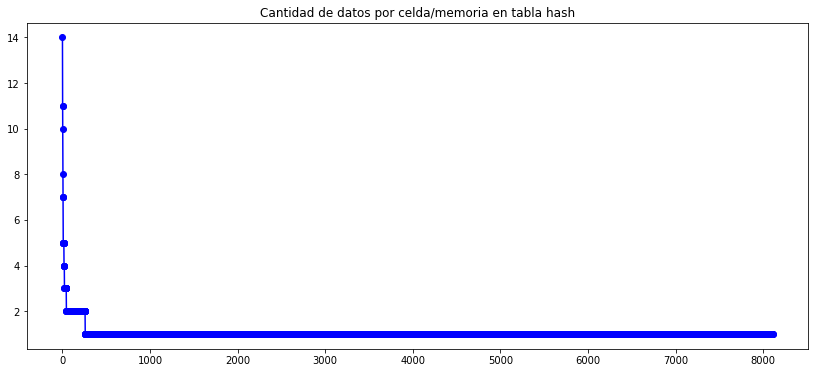

Cantidad de memorias ocupadas:  8108
Validación-----
Cantidad de datos a llenar la tabla hash:  2829


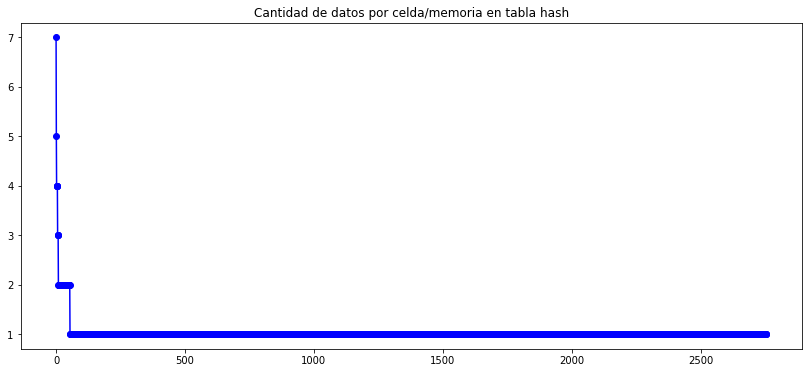

Cantidad de memorias ocupadas:  2756


In [20]:
print("Cantidad de memorias en tabla hash: ",2**Nb)

valores_unicos, count_hash =  hash_analysis(train_hash)
print("Entrenamiento----")
print("Cantidad de datos a llenar la tabla hash: ",train_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

valores_unicos, count_hash =  hash_analysis(val_hash)
print("Validación-----")
print("Cantidad de datos a llenar la tabla hash: ",val_hash.shape[0])
plt.figure(figsize=(14,6))
plt.plot(sorted(list(count_hash.values()))[::-1],'bo-')
plt.title("Cantidad de datos por celda/memoria en tabla hash")
plt.show()
print("Cantidad de memorias ocupadas: ",len(valores_unicos))

Se puede ver que se ocupan varias celdas de memorias gracias a la restricción de las variables latentes en el VAE, donde en la mayoría de los casos se asigna una única dirección de memoria para un objeto, obteniendo una tabla *hashing* distribuidamente poblada.  

> Y si se varía el número de bits?

Cantidad de memorias en tabla hash:  256
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  10060
Cantidad de memorias ocupadas hash1:  256
Cantidad de memorias ocupadas hash2:  252


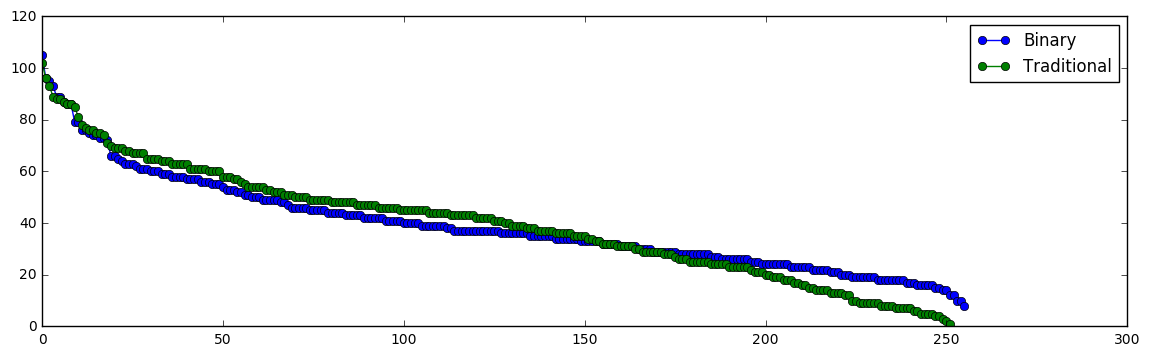

Pruebas-----
Cantidad de datos a llenar la tabla hash:  2280
Cantidad de memorias ocupadas hash1:  252
Cantidad de memorias ocupadas hash2:  234


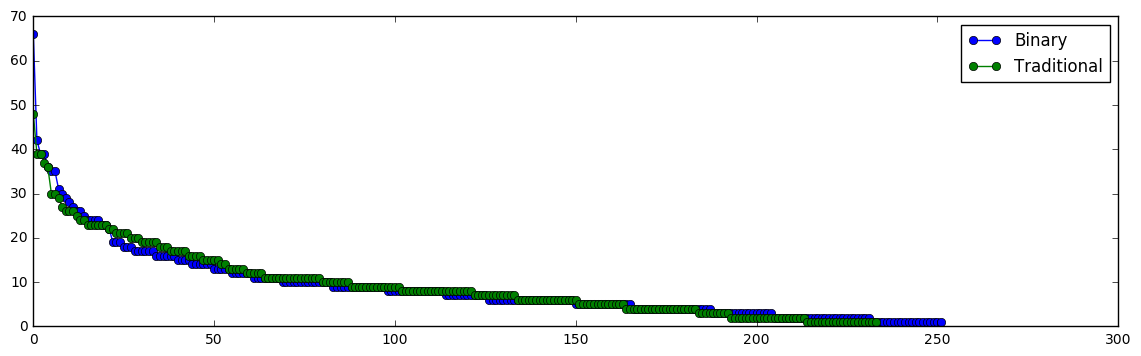

In [91]:
#plot together--8 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

Cantidad de memorias en tabla hash:  16
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  10060
Cantidad de memorias ocupadas hash1:  16
Cantidad de memorias ocupadas hash2:  16


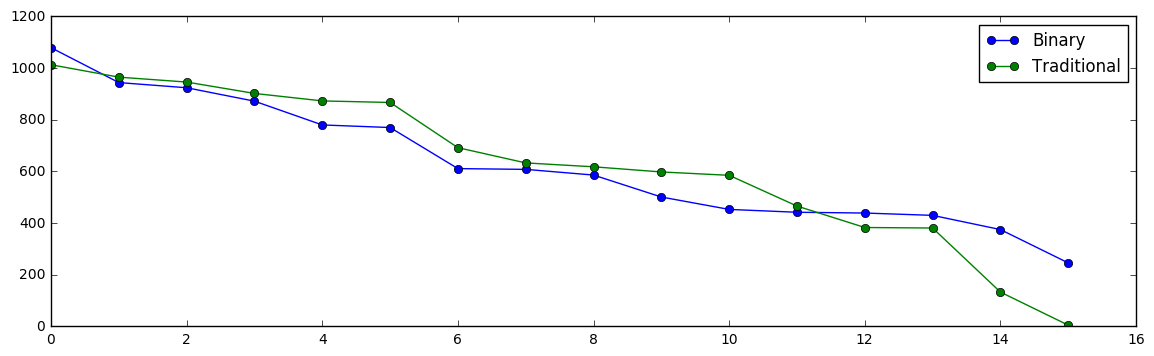

Pruebas-----
Cantidad de datos a llenar la tabla hash:  2280
Cantidad de memorias ocupadas hash1:  16
Cantidad de memorias ocupadas hash2:  16


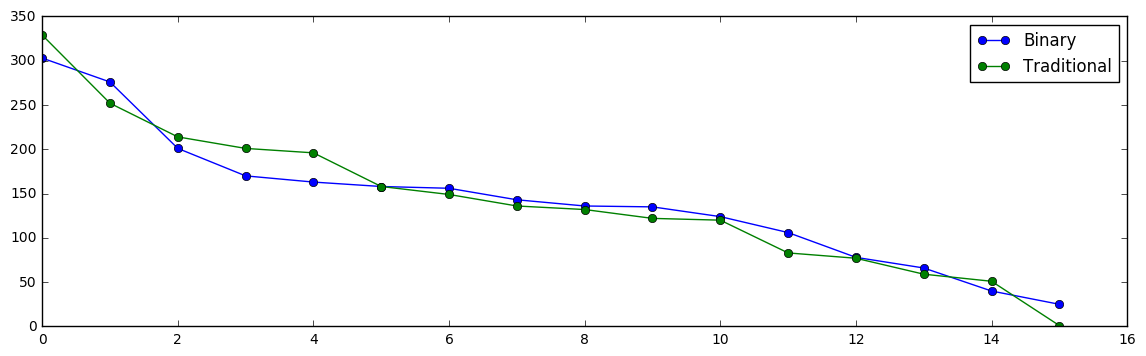

In [94]:
#plot together--- 4 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test_input)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

In [19]:
#Normal AE
Nb = 8
pre_encoder = define_pre_encoder(X_total_input.shape[1], layers=2,units=500,BN=True)
decoder = define_generator(Nb,X_total_input.shape[1],layers=2,units=500,BN=True) #2 layers?
## Encoder
x = Input(shape=(X_total_input.shape[1],))
hidden = pre_encoder(x)
code = Dense(Nb,activation='sigmoid')(hidden) #sigmoid?
encoder = Model(x, code) # build a model to project inputs on the latent space
## Decoder
output = decoder(code)
normal_AE = Model(x, output)
normal_AE.summary()

normal_AE.compile(optimizer='adam',loss='categorical_crossentropy')
normal_AE.fit(X_total_input,X_total,epochs=50,batch_size=100,verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
pre-encoder (Sequential)     (None, 500)               5255000   
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 4008      
_________________________________________________________________
generator/decoder (Sequentia (None, 10000)             5269000   
Total params: 10,528,008
Trainable params: 10,524,008
Non-trainable params: 4,000
_________________________________________________________________


Cantidad de memorias en tabla hash:  256
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  11314


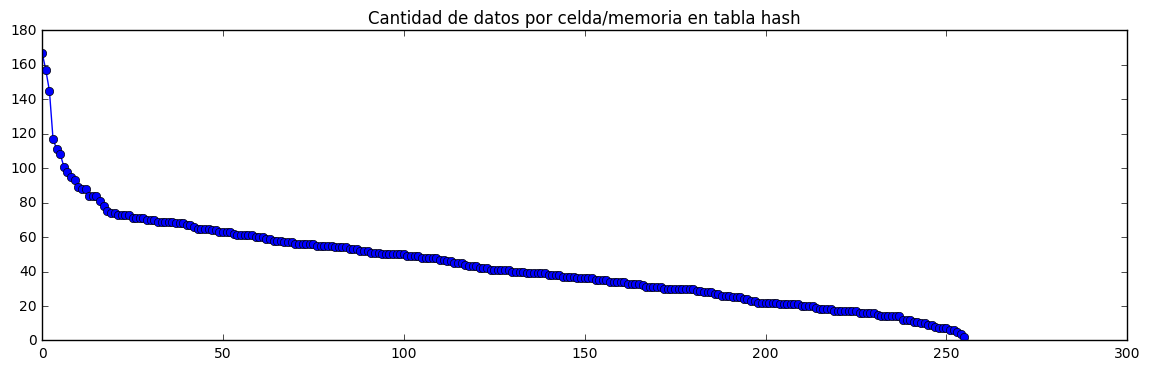

Cantidad de memorias ocupadas:  256
Pruebas-----
Cantidad de datos a llenar la tabla hash:  7532


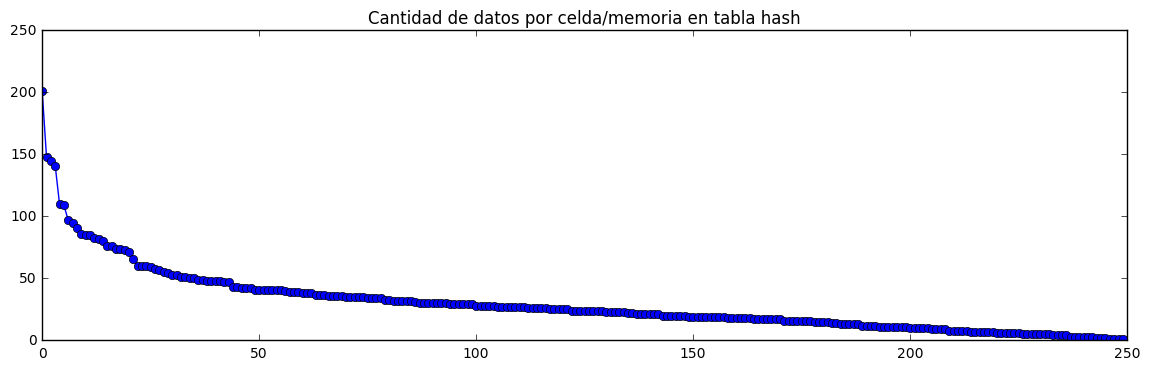

Cantidad de memorias ocupadas:  250


In [20]:
#Normal AE -- binary
probas_total = encoder.predict(X_total_input)
probas_test = encoder.predict(X_test_input)
train_hash = (probas_total > 0.5)*1
test_hash = (probas_test > 0.5)*1
plot_cells_distribution(Nb,train_hash,test_hash)

Los resultados se mantienen al variar los datasets, así que se muestra unicamente uno. El autoencoder clásico, muestra comportamiento similar, exceptuando quizás por una leve falta de generalización en el conjunto objetivo (de pruebas), ésto quiere decir que la hipótesis de que la distribución repartida de las celdas era debido al autoencoder variacional **estaba erronea**, ya que el autoencoder clásico lo logra. Respecto a quién logra una mejor distribución uniforme de las casillas depende, ya que por ejemplo en reuters lo logra el VAE tradicional, mientras que en snippets lo logra el VAE binario.  
**Resultado esperado**: se mantiene la idea de que se distribuyen los datos a través de todas las casillas disponibles, mientras que si se tiene las casillas suficientes va haber un dato por cada casilla.

In [54]:
#iterar sobre el resto de los bits y ver sus palabras mas frecuentes
def show_probable_words(topKwords,samplebits):
    probable_words = []
    for i in range(Nb):
        b = np.zeros((1,Nb))
        b[0,i] = 1 #solo un bit con uno

        reconstruct_data = generator_Bvae.predict(b)
        probable_words.append(get_topk_probably_words(reconstruct_data[0],K=topKwords))
    
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)
    t = Table()
    for b in bits:
        t["bit "+ str(b)] = probable_words[b]
    return t

A continuación se muestrean las 12 palabras más frecuentes de 8 *bits*  aleatorios distintos en el modelo.

In [26]:
print("20 Newsgroup")
show_probable_words(12,8)

20 Newsgroup


bit 22,bit 13,bit 5,bit 14,bit 29,bit 9,bit 30,bit 18
str12,str7,str12,str12,str13,str13,str13,str13
mimsy,megatek,rigorous,invitation,rigorous,complexity,heterosexual,newman
hopper,lbl,complexity,inconsistent,governing,heterosexual,invitation,likelihood
newman,newman,hubble,ehrlich,p00261,likelihood,pythagorean,slac
complexity,acme,mimsy,lbl,ebay,inconsistent,preservation,bernard
heterosexual,grief,likelihood,asia,eager,lbl,dani,rigorous
slac,ccc,inconsistent,kou,bernard,skeptic,harassment,sax
lbl,amdahl,finite,newman,inaccurate,presidential,homosexuality,dsi
dani,fuer,sl2,guidance,misunderstand,prohibits,lbl,introductory
hubble,rusnews,refutation,jhuapl,dishonest,homosexuality,asia,ranting


In [112]:
print("20 Newsgroup--collocations")
show_probable_words(12,8)

20 Newsgroup--collocations


bit 8,bit 4,bit 26,bit 5,bit 15,bit 27,bit 3,bit 7
str30,str24,str30,str27,str30,str30,str30,str30
communication greenbelt usa,article pitt,communication greenbelt usa,berkeley line,distribution sci line,organization express access,posting host access,organization express access
california berkeley line,organization sgi,communication greenbelt,ibm austin,article blue,posting host access,host access digex,express access
communication greenbelt,berkeley line,online communication greenbelt,organization express access,drive scsi,host access digex,communication greenbelt usa,organization express
online communication greenbelt,ibm austin,organization express access,california berkeley line,chapel hill,distribution sci line,organization express access,posting host access
berkeley line,gordon bank writes,organization express,posting host access,berkeley line,express access,online communication greenbelt,host access digex
mild,bbn,express access,express access,communication greenbelt,organization express,express access,express access online
distribution sci line,university western,express access online,host access digex,communication greenbelt usa,communication greenbelt usa,organization express,access online
frontier,california berkeley line,chapel hill,organization express,online communication greenbelt,express access online,communication greenbelt,access online communication
ulysses,wpd sgi,access online,express access online,california berkeley line,communication greenbelt,express access online,communication greenbelt usa


En el dataset de *20 Newsgroup* se puede ver por ejemplo que el *bit* 9 contiene palabras como *heterosexual*, *presidential*, *prohibits*, *eternity* y *homosexuality*, pudiendo ser asociados a textos que contengan una discusión política de la sexualidad o palabras con connotación negativa. El *bit* 13 podría estar asociado a empresas u organizaciones/entidades conocidas, al contener *newman*, *ebay*, *hubble* y *acme*.

In [46]:
print("Reuters")
show_probable_words(12,8)

Reuters


bit 9,bit 31,bit 21,bit 7,bit 14,bit 29,bit 5,bit 17
str11,str14,str12,str12,str12,str10,str14,str11
danger,device,eed,printing,murray,toronto,responsibility,printing
object,recognize,consummated,ica,hindered,receivable,weakening,analyze
consummated,responsibility,analyze,elmd,baby,catalyst,recognize,device
relate,analyze,recognize,projecting,accurate,murray,analyze,dallas
hostile,printing,moines,analyze,proceeding,stretch,edition,catalyst
weakening,undoubtedly,cancellation,baby,justify,printing,colo,exploring
cellular,describing,severance,kpk,master,analyze,sierra,proof
printing,existence,colo,device,uneconomic,projecting,eighth,elmd
uneconomic,projecting,defensive,undoubtedly,jacksonville,edmonton,mature,object


In [103]:
print("Reuters--collocations")
show_probable_words(12,8)

Reuters--collocations


bit 10,bit 17,bit 30,bit 0,bit 2,bit 20,bit 23,bit 21
str19,str22,str19,str19,str19,str19,str19,str19
company share,dlrs unit,fit,corp said board,corp said board,company share,corp said board,said pay
corp said board,second largest,second largest,receive mln dlrs,dlrs unit,receive mln dlrs,dlrs unit,said planned
manufacture,said pay,said pay,sustained,said pay,expected close,said pay,participate
dlrs unit,dlrs worth,company share,dlrs unit,form new,said board approved,receive mln dlrs,shareholder company
sale billion dlrs,receive mln dlrs,financially,expected close,said board approved,dlrs unit,salomon brother,stake company
said pay,said make,stake company,fit,said considering,fit,said board approved,receive mln dlrs
recommend,said considering,advise,shareholder company,dividend share,cheap,company share,company share
shareholder company,told reuters interview,sale billion dlrs,close april,expected close,said pay,sale billion dlrs,corp said board
announce,mln dlrs worth,expected result,payment said,rise dollar,corp said board,mob,holder record


En el dataset de *Reuters* el *bit* 31 alberga conceptos asociados a computadores, como lo son *device*, *analyze*, *printing*, *projecting*, *exploring* y *object*. 

In [61]:
print("Snippets")
show_probable_words(12,8)

Snippets


bit 29,bit 25,bit 0,bit 30,bit 15,bit 24,bit 19,bit 4
str12,str14,str12,str12,str12,str13,str12,str12
interaction,interaction,biogeography,emc,chamber,managing,gymnastics,biogeography
biogeography,biogeography,interactive,investor,agency,biogeography,chamber,emc
gymnastics,composer,composer,biogeography,patient,emc,biogeography,gymnastics
requirement,radiology,gymnastics,requirement,biogeography,ecology,cam,interaction
specializes,gymnastics,chamber,unl,emc,visualization,healthcare,beginner
logo,patient,campus,chamber,cdc,lighting,focusing,consisting
consisting,seattle,ballet,ecology,specializes,cable,cdc,newsday
butler,creative,lesson,interaction,composer,credible,flat,unl
emc,ballet,requirement,beginner,drama,interaction,interactive,historic


In [122]:
print("Snippets--collocations")
show_probable_words(12,8)

Snippets--collocations


bit 17,bit 30,bit 9,bit 4,bit 15,bit 7,bit 18,bit 0
str20,str9,str20,str10,str20,str20,str18,str20
indexed,flight,flight,abroad,nato,indexed,firm,unlimited
treaty,real,search web,sql,indexed,jesus,indexed,firm
firm,steam,treaty,real,search web,sql,unlimited,web browser
accessibility,editing,web search,indexed,web search,columbia edu,web search,research development
scholarly,firm,nato,issued,research development,manhattan,ticket information,academic research
nato,chronicle,research development,applicant,research research,real,search web,flight
counselor,scholarly,firm,firm,treaty,monthly magazine,btinternet,applicant
link resource,issued,editing,unlimited,soldier,research development,wideless,conversion
resource english,sql,sql,web search,tree,flight,manhattan,treaty


En el dataset de *Snippets* se puede ver por ejemplo que el *bit* 30 almacena conceptos como *ecology*, *geographical* y *wildlife*, pudiendo ser asociado a textos que hablen de la temática de fauna. El bit *25* contiene términos asociados a salud o deporte, como *radiology*, *gymnastics*, *patient* y *strength*.

## Trabajo Futuro
Experimentar con redes recurrentes como el modelo de *encoder* y otra para el modelo de *decoder*/*generator*.

### Referencias
---
[1] Salakhutdinov, R., & Hinton, G. (2009). *Semantic hashing*. International Journal of Approximate Reasoning, 50(7), 969-978.  
[2] Chaidaroon, S., & Fang, Y. (2017, August). *Variational deep semantic hashing for text documents*. In Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval (pp. 75-84). ACM.  
[3] Chaidaroon, S., Ebesu, T., & Fang, Y. (2018). *Deep Semantic Text Hashing with Weak Supervision*. SIGIR.  
[4] Maddison, C. J., Mnih, A., & Teh, Y. W. (2016). The concrete distribution: A continuous relaxation of discrete random variables. arXiv preprint arXiv:1611.00712.  
[5] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.